## 0. Build the package with cmake and install sz3py target

```bash
mkdir build && cd build
cmake ..
cmake --build . --target sz3py
cmake --install .
```

The build system will install a .so file into `${PROJECT_ROOT}/tools/bindings/sz3py` folder. `pip install ${PROJECT_ROOT}/tools/bindings` should install the sz3py package into the selected python environment.


In [2]:
import sz3py
dir(sz3py)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'collect_prediction_data',
 'compress',
 'decompress',
 'safeMPIFinalize',
 'test',
 'verify_decompressed_file_in_memory']

In [3]:
sz3py.__file__

'/home/yuanjian/miniconda3/envs/event_detection/lib/python3.10/site-packages/sz3py/sz3py.cpython-310-x86_64-linux-gnu.so'

## 1. Verify the .so file is correctly built

We can use `ctypes` and `importlib.util` to verify if the dynamic link library is correctly built.

In [4]:
import ctypes
lib = ctypes.CDLL("../tools/bindings/sz3py/sz3py.cpython-310-x86_64-linux-gnu.so")
print(lib)  

<CDLL '../tools/bindings/sz3py/sz3py.cpython-310-x86_64-linux-gnu.so', handle 9a98860 at 0x7a11800412d0>


In [5]:
import importlib.util
import os

so_path = "/home/yuanjian/miniconda3/envs/event_detection/lib/python3.10/site-packages/sz3py/sz3py.cpython-310-x86_64-linux-gnu.so"
spec = importlib.util.spec_from_file_location("sz3py", so_path)
sz3py = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sz3py)

print(dir(sz3py))  

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'collect_prediction_data', 'compress', 'decompress', 'safeMPIFinalize', 'test', 'verify_decompressed_file_in_memory']


## 2. Compress NYX dataset

In [1]:
from pathlib import Path

DATA_PATH = Path("/media/briannas/Research/compression-data/nyx/")

COMPRESSED_DATA_PATH = Path("/media/briannas/Research/compression-data/compressed/")

temperature_raw_file_path = DATA_PATH / "temperature.f32"
temperature_compressed_file_path = COMPRESSED_DATA_PATH / "temperature.f32.szsplit"
temperature_decompressed_file_path = COMPRESSED_DATA_PATH  / "temperature.f32.dp"

In [7]:
compress_args = [
    "compress",
    "-i", str(temperature_raw_file_path),
    "-o", str(temperature_compressed_file_path),
    "-d", "512", "512", "512",
    "-e", "0.01",
    "--mode", "layer",
    "--depth", "32",
    # "--mpi",
    # running a mpi program requires the `mpirun` prorgam instead of inside Python
    "--threads", "4"
]
compress_args

['compress',
 '-i',
 '/media/briannas/Research/compression-data/nyx/temperature.f32',
 '-o',
 '/media/briannas/Research/compression-data/compressed/temperature.f32.szsplit',
 '-d',
 '512',
 '512',
 '512',
 '-e',
 '0.01',
 '--mode',
 'layer',
 '--depth',
 '32',
 '--threads',
 '4']

In [8]:
import sz3py
sz3py.compress(compress_args)

0

In [9]:
decompress_args = [
    "decompress",
    "-i", str(temperature_compressed_file_path),
    "-o", str(temperature_decompressed_file_path),
    "-d", "512", "512", "512",
    "-e", "0.01",
    "--mode", "layer",
    "--depth", "32",
    # "--mpi",
    # running a mpi program requires the `mpirun` prorgam instead of inside Python
    "--threads", "4"
]
decompress_args

['decompress',
 '-i',
 '/media/briannas/Research/compression-data/compressed/temperature.f32.szsplit',
 '-o',
 '/media/briannas/Research/compression-data/compressed/temperature.f32.dp',
 '-d',
 '512',
 '512',
 '512',
 '-e',
 '0.01',
 '--mode',
 'layer',
 '--depth',
 '32',
 '--threads',
 '4']

In [10]:
sz3py.decompress(decompress_args)

0

## 3. Verify the PSNR and RMSE of the decompressed data

In [13]:

import sz3py
PSNR, RMSE = sz3py.verify_decompressed_file_in_memory(
    str(temperature_raw_file_path),
    str(temperature_decompressed_file_path)
)
print(f"PSNR: {PSNR}, RMSE: {RMSE}")

Min=2280.975830078125, Max=4782583.5, range=4780302.524169921875
Max absolute error = 0.0098
Max relative error = 2E-09
Max pw relative error = 4.2E-06
PSNR = 178.564818, NRMSE= 1.179666122E-09
normError = 65.331019, normErr_norm = 0.000000
acEff=1.000000
PSNR: 178.5648178523013, RMSE: 1.179666121962659e-09


## 4. Visualize the decompressed data and raw data

In [10]:
def get_partial_preview_data(dimension: list[int], data_file: str, layer_number: int, is_float64: bool=False):
    import numpy as np
    from matplotlib.figure import Figure
    from matplotlib import pyplot as plt
    from io import BytesIO
    if len(dimension) != 3: 
        # error, this function only deals with 3D tensor
        return (-1, -1, -1)
    
    layer_size = dimension[0] * dimension[1]
    data_type = np.float32 if not is_float64 else np.float64
    
    with open(data_file, 'rb') as f:
        f.seek(layer_number * layer_size * np.dtype(data_type).itemsize)
        layer_data = np.fromfile(f, dtype=data_type, count=layer_size)
        layer_data = layer_data.reshape(dimension[0], dimension[1])

    # print(layer_data)
    # print("---------")

    fig = Figure(dpi=100)
    fig.subplots_adjust(bottom=0, top=1, left=0, right=1)
    ax = fig.add_subplot(111)
    data_min, data_max = np.min(layer_data), np.max(layer_data)
    ax.imshow(layer_data, cmap=plt.get_cmap('rainbow'), norm=plt.Normalize(vmin=data_min, vmax=data_max), aspect='auto')
    buf = BytesIO()
    fig.savefig(buf, format='png')

    return (buf, data_min, data_max)

In [11]:
layer_number = 400
dimension = [512, 512, 512]
is_float64 = False
raw_image_data, raw_data_min, raw_data_max = get_partial_preview_data(dimension, temperature_raw_file_path, layer_number, is_float64)
dp_image_data, dp_data_min, dp_data_max = get_partial_preview_data(dimension, temperature_decompressed_file_path, layer_number, is_float64)

In [12]:
raw_image_data

In [13]:
from PIL import Image
import numpy as np
raw_image = Image.open(raw_image_data)
raw_image_array = np.array(raw_image)
dp_image = Image.open(dp_image_data)
dp_image_array = np.array(dp_image)
raw_image_array.shape, dp_image_array.shape

((480, 640, 4), (480, 640, 4))

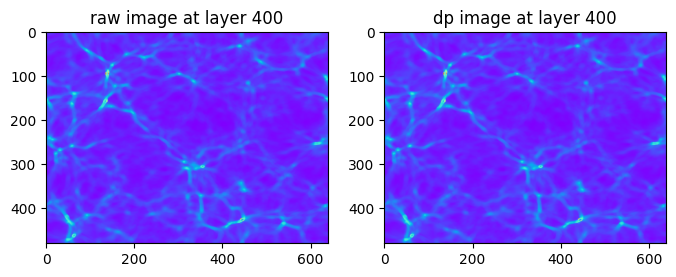

In [14]:
import matplotlib
from matplotlib import pyplot as plt

figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(raw_image_array)
axes[0].set_title(f"raw image at layer {layer_number}")

axes[1].imshow(dp_image_array)
axes[1].set_title(f"dp image at layer {layer_number}")

plt.show()

## 5. Collect the data for prediction

In [6]:
import sz3py

collected_data = sz3py.collect_prediction_data( 
    inputFilePath=str(temperature_raw_file_path),
    dims=[512, 512, 512],
    error_bound=0.1
)

print(collected_data)

[['filename', 'size', 'num', 'min', 'max', 'valueRange', 'avgValue', 'entropy', 'zeromean_variance', 'total_overhead_time', 'total_overhead_percentage', 'prediction_overhead_time', 'prediction_overhead_percentage', 'ABS Error Bound', 'Set Error Bound', 'avg_lorenzo', 'quant_entropy', 'predicted CR', 'predicted bitrate', 'p0', 'P0', 'CPTime', 'CR', 'DPTime', 'WriteTime', 'PSNR', 'RMSE'], ['temperature.f32', '536870912', '134217728', '2280.975830', '4782583.500000', '4780302.524170', '8453.289277', '7.006938', '5683602035511.926758', '47.846669', '5.041114', '1.713009', '0.180482', '0.100000', 'ABS', '0.039148', '8.343272', '2.165327', '14.778371', '0.001957', '0.001192', '9.491290', '2.835758', '11.723098', '3.761684', '155.861034', '0.000000']]compression ratio = 2.84 
compression time = 9.491290
compressed data file = tmp.sz3

Decompression finished successfully
Min=2280.975830078125, Max=4782583.5, range=4780302.524169921875
Max absolute error = 0.2
Max relative error = 4.2E-08
Max p

In [7]:
import pandas as pd
columns = collected_data[0]
data = collected_data[1:]
df = pd.DataFrame(data, columns=columns)
df

,filename,size,num,min,max,valueRange,avgValue,entropy,zeromean_variance,total_overhead_time,...,predicted CR,predicted bitrate,p0,P0,CPTime,CR,DPTime,WriteTime,PSNR,RMSE
0,temperature.f32,536870912,134217728,2280.975830,4782583.500000,4780302.524170,8453.289277,7.006938,5683602035511.926758,47.846669,...,2.165327,14.778371,0.001957,0.001192,9.491290,2.835758,11.723098,3.761684,155.861034,0.000000
